In [1]:
!echo "Last updated: `date`"

Last updated: Wed Aug 19 15:57:36 PDT 2020


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
from sklearn.datasets import make_moons
from tqdm import trange

sigmoid = lambda x: 1 / (1 + np.exp(-x))

# Alias.
SqExpKernel = tfp.math.psd_kernels.ExponentiatedQuadratic

# Default data type for tensorflow tensors.
# dtype = np.float32
dtype = np.float64

# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

# Set number of cores.
# tf.config.threading.set_inter_op_parallelism_threads(4)

In [3]:
def plot_kernel_params(samples, kernel_params=['alpha', 'rho', 'beta'], figsize=(8, 3)):
    plt.figure(figsize=figsize)
    for i in range(len(kernel_params)):
        plt.subplot(1, len(kernel_params), i + 1)
        param = kernel_params[i]
        plt.hist(samples[param], bins=30, density=True)
        plt.xlabel(param)
        plt.ylabel('density')
        plt.title("Histograhm of {}".format(param))
    plt.tight_layout()

def gen_grid(X, n, return_each=False, eps=0):
    x0, x1 = np.meshgrid(np.linspace(X[:, 0].min()-eps, X[:, 0].max()+eps, n),
                         np.linspace(X[:, 1].min()-eps, X[:, 1].max()+eps, n))
    
    Y = np.stack([x0.ravel(), x1.ravel()], axis=-1).astype(dtype)
    
    if return_each:
        return Y, x0.astype(dtype), x1.astype(dtype)
    else:
        return Y
    
def plot_data(X, y, **kwargs):
    colors = np.array(['blue', 'red'])
    plt.scatter(X[:, 0], X[:, 1], c=colors[y], **kwargs)

def plot_latent_fn(samples, X, y, algo, grid_length=30, figsize=np.array([8, 3]) * 1.2,
                   vmin_sd=0, vmax_sd=None):
    index_points, x0, x1 = gen_grid(X, grid_length, return_each=True, eps=0.5)
    
    alpha = samples['alpha']
    rho = samples['rho']
    beta = samples['beta']
    eta = samples['eta']
    nsamples = len(beta)
    
    def onepred(i):
        f = compute_f(alpha[i], rho[i], beta[i], eta[i])
        gprm = tfd.GaussianProcessRegressionModel(kernel=SqExpKernel(alpha[i], rho[i]),
                                                  index_points=index_points.astype(dtype),
                                                  observation_index_points=X,
                                                  jitter=1e-6, observations=f)
        return gprm.sample().numpy()
    
    preds = np.stack([onepred(i) for i in trange(nsamples)])

    plt.figure(figsize=figsize)
    # Plot mean function.
    plt.subplot(1, 2, 1)
    plt.contourf(x0, x1, sigmoid(preds).mean(0).reshape(x0.shape), 101,
                 cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.colorbar();
    plot_data(X, y, edgecolors='orange');
    plt.xticks([]); plt.yticks([]);
    plt.title("Posterior Mean Function ({})".format(algo));

    # Plot SD function.
    plt.subplot(1, 2, 2)
    plt.contourf(x0, x1, sigmoid(preds).std(0).reshape(x0.shape), 101,
                 cmap=plt.get_cmap('Oranges'), vmin=vmin_sd, vmax=vmax_sd)
    plt.colorbar();
    plot_data(X, y, edgecolors='black');
    plt.xticks([]); plt.yticks([]);
    plt.title("Posterior SD Function ({})".format(algo));

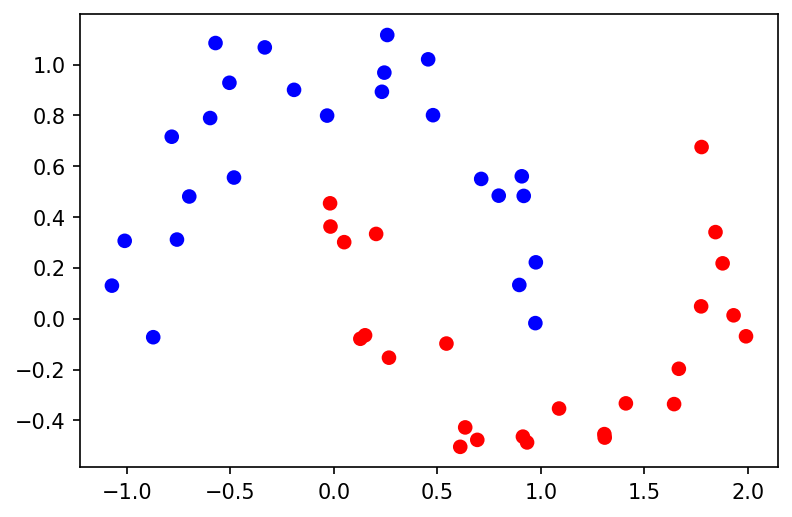

In [4]:
# Read data
path_to_data = '../data/gp-classify-data-N50.json'
simdata = json.load(open(path_to_data))

# Store data.
X = np.stack([simdata['x1'], simdata['x2']], axis=-1).astype(dtype)
y = np.array(simdata['y'])

plot_data(X, y)

In [5]:
# Specify GP model.

def compute_LK(alpha, rho, X, jitter=1e-6):
    kernel = SqExpKernel(alpha, rho)
    K = kernel.matrix(X, X) + tf.eye(X.shape[0], dtype=dtype) * jitter
    return tf.linalg.cholesky(K)

def compute_f(alpha, rho, beta, eta):
    LK = compute_LK(alpha, rho, X)
    f = tf.linalg.matvec(LK, eta)  # LK * eta, (matrix * vector)
    return f + beta[..., tf.newaxis]

# GP Binary Classification Model.
gpc_model = tfd.JointDistributionNamed(dict(
    alpha=tfd.LogNormal(dtype(0), dtype(1)),
    rho=tfd.LogNormal(dtype(0), dtype(1)),
    beta=tfd.Normal(dtype(0), dtype(1)),
    eta=tfd.Sample(tfd.Normal(dtype(0), dtype(1)),
                   sample_shape=X.shape[0]),
    # NOTE: `Sample` and `Independent` resemble, respectively,
    # `filldist` and `arraydist` in Turing.
    obs=lambda alpha, rho, beta, eta: tfd.Independent(
        tfd.Bernoulli(logits=compute_f(alpha, rho, beta, eta)),
        reinterpreted_batch_ndims=1) 
))

# Check shapes are correct.
print(gpc_model.sample()['obs'].shape)
print(gpc_model.sample()['eta'].shape)
print(gpc_model.sample([2])['obs'].shape)
print(gpc_model.sample([2])['eta'].shape)
print(gpc_model.sample([2,3])['obs'].shape)
print(gpc_model.sample([2,3])['eta'].shape)

(50,)
(50,)
(2, 50)
(2, 50)
(2, 3, 50)
(2, 3, 50)


**NOTE:** This (equivalent) version mixes poorly.

```python
gpc_model = tfd.JointDistributionNamed(dict(
    alpha=tfd.LogNormal(dtype(0), dtype(1)),
    rho=tfd.LogNormal(dtype(0), dtype(1)),
    beta=tfd.Normal(dtype(0), dtype(1)),
    f=lambda alpha, rho, beta: tfd.GaussianProcess(
        mean_fn=lambda x: beta[..., tf.newaxis] + np.zeros(x.shape[0]),
        kernel=SqExpKernel(amplitude=alpha, length_scale=rho, feature_ndims=1),
        jitter=1e-3, index_points=X),
    obs=lambda f: tfd.Independent(
        tfd.Bernoulli(logits=f), reinterpreted_batch_ndims=1)
))
```

**NOTE:** Alternate implementation via `JointDistributionCoroutine`.
This requires some modifications to the code below.

```python
Root = tfd.JointDistributionCoroutine.Root
@tfd.JointDistributionCoroutine
def gpc_model():
    alpha = yield Root(tfd.LogNormal(dtype(0), dtype(1)))
    rho = yield Root(tfd.LogNormal(dtype(0), dtype(1)))
    beta = yield Root(tfd.Normal(dtype(0), dtype(1)))
    eta = yield Root(tfd.Independent(
        tfd.Normal(np.zeros(X.shape[0], dtype=dtype), dtype(1)),
        reinterpreted_batch_ndims=1))
    obs = yield tfd.Independent(
        tfd.Bernoulli(logits=compute_f(alpha, rho, beta, eta)),
        reinterpreted_batch_ndims=1) 

```

In [6]:
# Run graph to make sure it works.
_ = gpc_model.sample()
# _ = gpc_model.sample([2])

# Parameters as they appear in model definition.
# NOTE: Initial values should be defined in order appeared in model.
ordered_params = ['alpha', 'rho', 'beta', 'eta']

# Initial values.
tf.random.set_seed(1)
s = gpc_model.sample()
initial_state = [s[key] for key in ordered_params]

# Bijectors (from unconstrained to constrained space)
bijectors = [
    tfp.bijectors.Exp(),  # alpha
    tfp.bijectors.Exp(),  # rho
    tfp.bijectors.Identity(),  # beta
    tfp.bijectors.Identity(),  # eta
]

# Unnormalized log posterior
def unnormalized_log_posterior(alpha, rho, beta, eta):
    return gpc_model.log_prob(alpha=alpha, rho=rho, beta=beta, eta=eta, obs=y)

In [7]:
def hmc_trace_fn(state, pkr):
    """
    state: current state in MCMC
    pkr: previous kernel result
    """
    result = pkr.inner_results
    return dict(is_accepted=result.is_accepted,
                target_log_prob=result.accepted_results.target_log_prob)
    
# @tf.function(autograph=False, experimental_compile=True)  # 33s
# @tf.function(autograph=False)  # 13s

@tfp.experimental.nn.util.tfcompile  # 14s
def run_hmc(num_results, num_burnin_steps):
      return tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state=initial_state,
          kernel=tfp.mcmc.TransformedTransitionKernel(
                     inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                         target_log_prob_fn=unnormalized_log_posterior,
                         step_size=0.05,
                         num_leapfrog_steps=20),
                     bijector=bijectors),
          trace_fn=hmc_trace_fn)

In [8]:
def nuts_trace_fn(state, pkr):
    """
    state: current state in MCMC
    pkr: previous kernel result
    """
    result = pkr.inner_results.inner_results
    return dict(is_accepted=result.is_accepted,
                target_log_prob=result.target_log_prob)
  
@tfp.experimental.nn.util.tfcompile  # 14s
def run_nuts(num_results, num_burnin_steps):
      return tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state=initial_state,
          kernel=tfp.mcmc.SimpleStepSizeAdaptation(
              tfp.mcmc.TransformedTransitionKernel(
                  inner_kernel = tfp.mcmc.NoUTurnSampler(
                      target_log_prob_fn=unnormalized_log_posterior,
                      max_tree_depth=10, step_size=0.05),
                  bijector=bijectors),
          num_adaptation_steps=num_burnin_steps,
          target_accept_prob=0.8),
          trace_fn=nuts_trace_fn)

Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
CPU times: user 2.65 s, sys: 59.2 ms, total: 2.71 s
Wall time: 2.84 s
CPU times: user 16.6 s, sys: 2.5 s, total: 19.1 s
Wall time: 8.71 s
Acceptance rate: 0.882


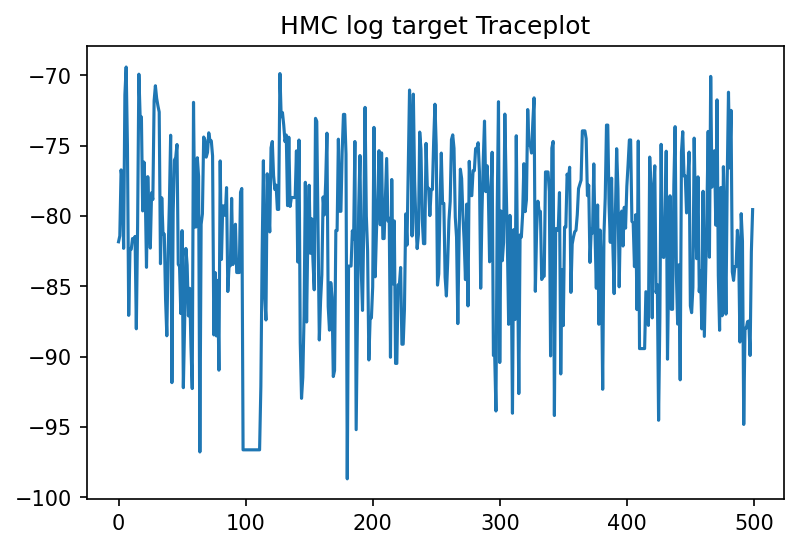

In [9]:
# set random seed
tf.random.set_seed(2)

# Compile
%time _ = run_hmc(1, 1)

# Run
%time [alpha, rho, beta, eta], hmc_stats = run_hmc(500, 500)

# Print acceptance rate.
print(f"Acceptance rate: {np.mean(hmc_stats['is_accepted'])}")

# Collect posterior samples.
hmc_samples = dict(alpha=alpha.numpy(), rho=rho.numpy(),
                   beta=beta.numpy(), eta=eta.numpy())

plt.plot(hmc_stats['target_log_prob'])
plt.title("HMC log target Traceplot");

Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
CPU times: user 4.78 s, sys: 67.3 ms, total: 4.85 s
Wall time: 4.54 s
CPU times: user 1min 50s, sys: 16.8 s, total: 2min 7s
Wall time: 52 s
Acceptance rate: 0.996


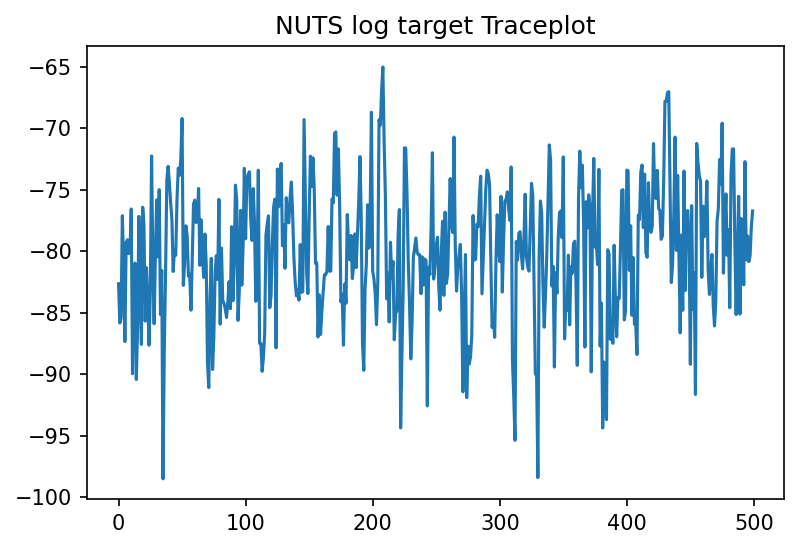

In [10]:
# set random seed
tf.random.set_seed(2)

# Compile
%time _ = run_nuts(1, 1)

# Run
%time [alpha, rho, beta, eta], nuts_stats = run_nuts(500, 500)

# Print acceptance rate.
print(f"Acceptance rate: {np.mean(nuts_stats['is_accepted'])}")

# Collect posterior samples.
nuts_samples = dict(alpha=alpha.numpy(), rho=rho.numpy(),
                    beta=beta.numpy(), eta=eta.numpy())

plt.plot(nuts_stats['target_log_prob'])
plt.title("NUTS log target Traceplot");

100%|██████████| 500/500 [00:30<00:00, 16.50it/s]


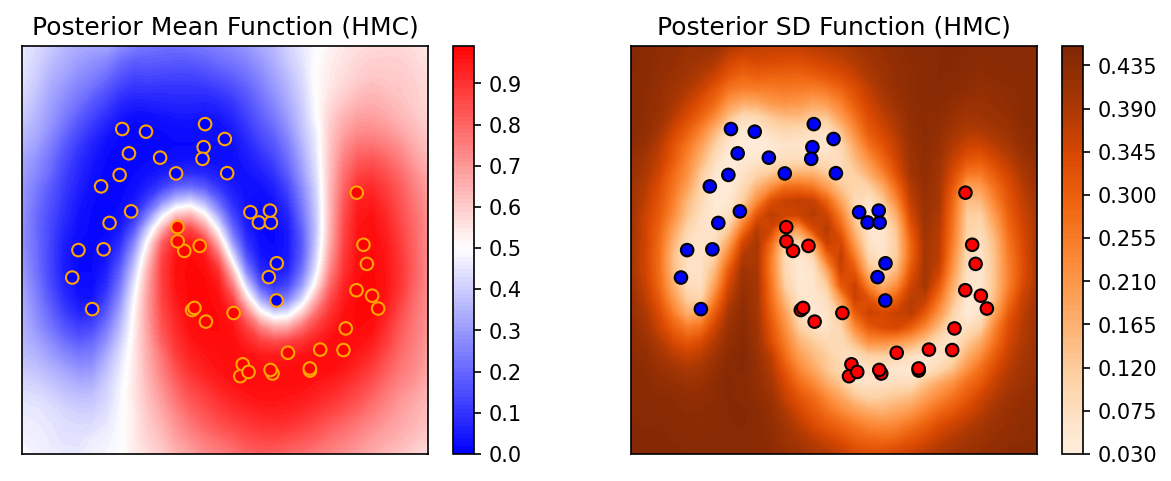

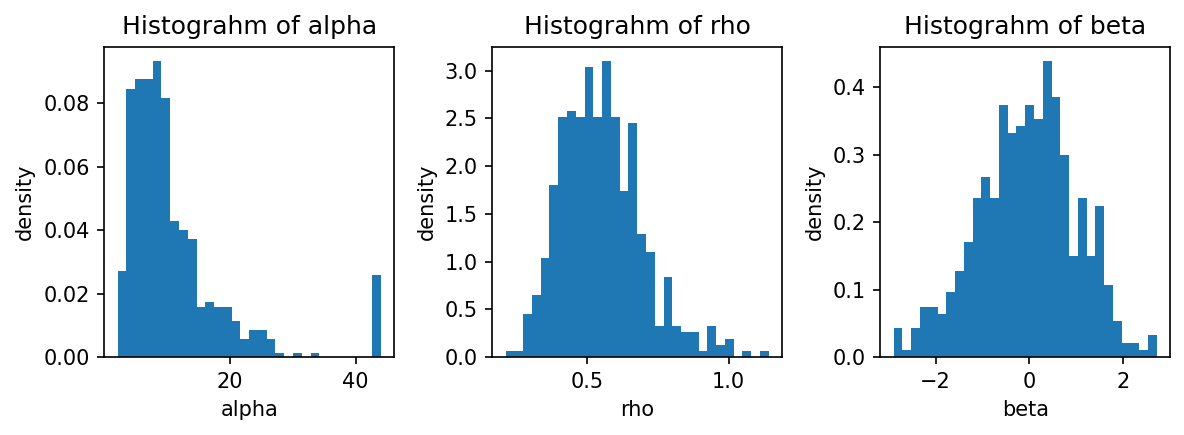

In [11]:
plot_latent_fn(hmc_samples, X, y, 'HMC')
plot_kernel_params(hmc_samples)

100%|██████████| 500/500 [00:30<00:00, 16.52it/s]


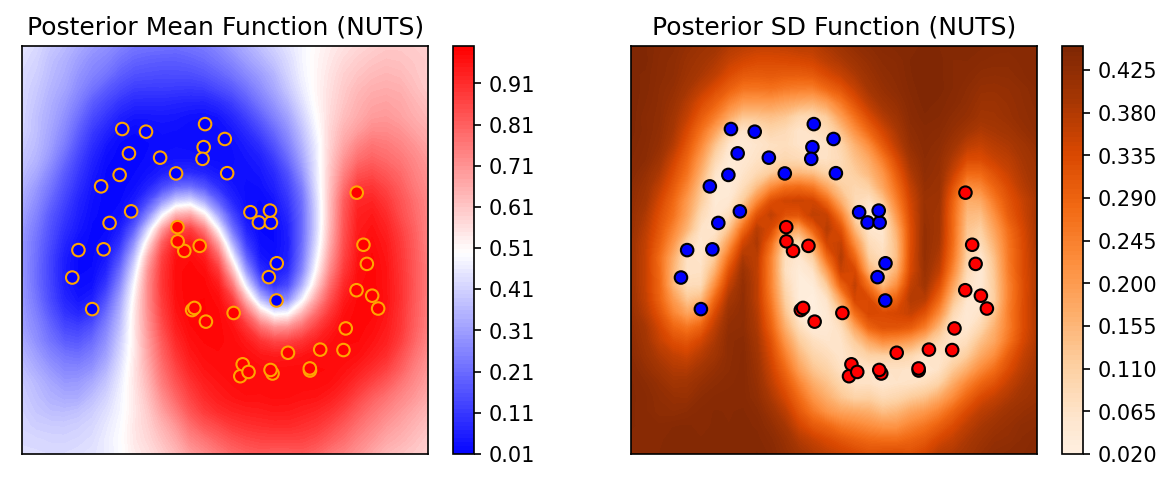

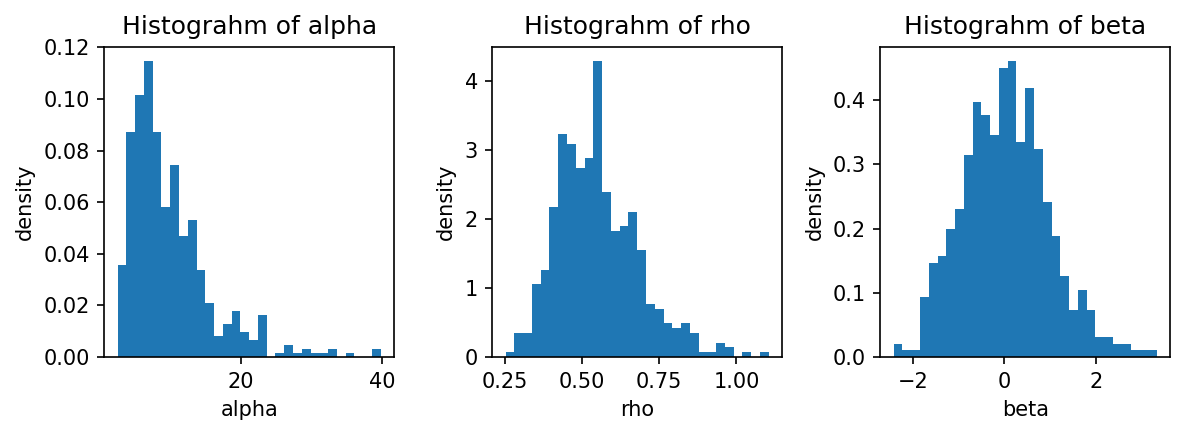

In [12]:
plot_latent_fn(nuts_samples, X, y, 'NUTS')
plot_kernel_params(nuts_samples)

## ADVI

In [88]:
# Variational distribution, which approximates the true posterior.
# ADVI is quite sensitive to initial distritbution.
tf.random.set_seed(3)

# Create variational parameters.
vp_dict = dict()
for key in ordered_params:
    param_shape = gpc_model.model[key].event_shape
    vp_dict[f'q{key}_loc'] = tf.Variable(tf.random.normal(param_shape, dtype=dtype),
                                         name=f'q{key}_loc')
    vp_dict[f'q{key}_rho'] = tf.Variable(tf.random.normal(param_shape, dtype=dtype),
                                         name=f'q{key}_rho')
    
# Create variational distribution.
surrogate_family = dict(alpha=tfd.LogNormal, rho=tfd.LogNormal,
                        beta=tfd.Normal, eta=tfd.Normal)
surrogate_posterior_dict = {
    key: surrogate_family[key](vp_dict[f'q{key}_loc'], tf.nn.softplus(vp_dict[f'q{key}_rho']))
    for key in ordered_params
}
surrogate_posterior_dict['eta'] = tfd.Independent(surrogate_posterior_dict['eta'],
                                                  reinterpreted_batch_ndims=1)
surrogate_posterior = tfd.JointDistributionNamed(
    surrogate_posterior_dict
)
    
# Function for running ADVI.
def run_advi(sample_size, num_steps):
    return tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=unnormalized_log_posterior,
        surrogate_posterior=surrogate_posterior,
        optimizer=tf.optimizers.Adam(learning_rate=1e-1),
        seed=1,
        sample_size=sample_size,  # ELBO samples.
        num_steps=num_steps)  # Number of iterations to run optimizer.

In [89]:
# Fit GP via ADVI.
%time losses = run_advi(sample_size=10, num_steps=1000)

CPU times: user 4.9 s, sys: 295 ms, total: 5.2 s
Wall time: 3.11 s


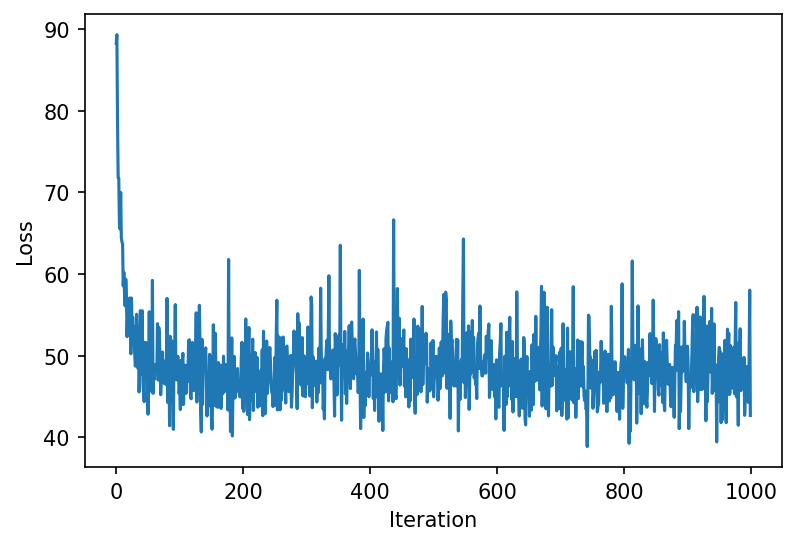

In [90]:
# Plot losses
plt.plot(losses.numpy());
plt.ylabel('Loss')
plt.xlabel('Iteration');

# Extract posterior samples from variational distributions.
advi_samples = surrogate_posterior.sample(500)
advi_samples = {k: advi_samples[k].numpy() for k in advi_samples}

100%|██████████| 500/500 [00:31<00:00, 16.06it/s]


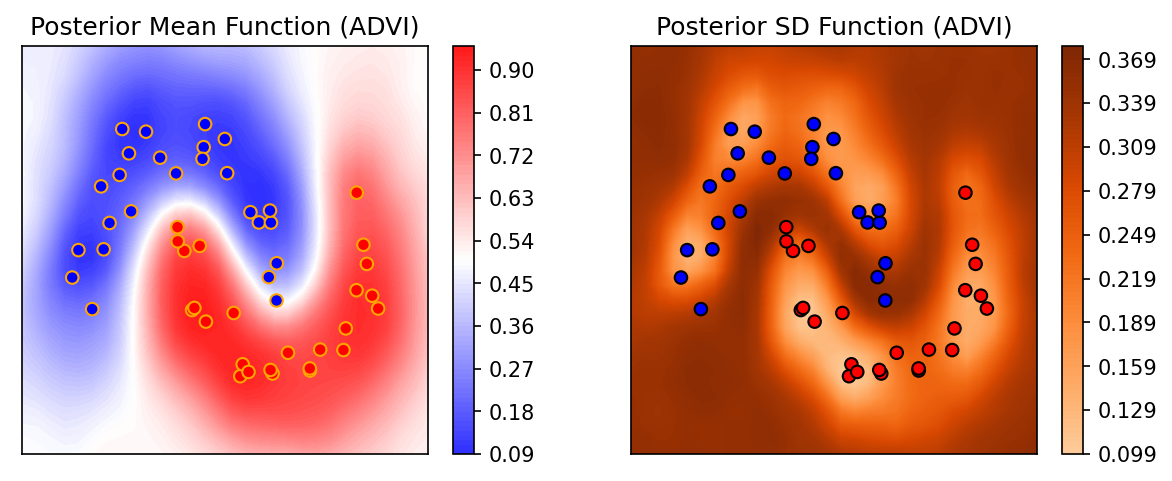

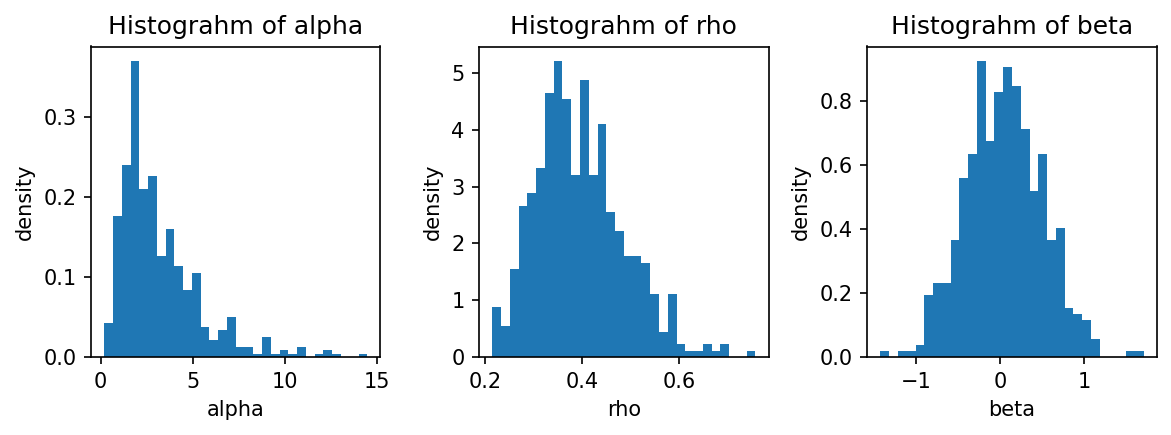

In [91]:
plot_latent_fn(advi_samples, X, y, 'ADVI')
plot_kernel_params(advi_samples)

**How to:**
- Get sampels of `f` during MCMC (using [`Deterministic`][1])?

[1]: https://github.com/tensorflow/probability/issues/601